In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
arunrk7_surface_crack_detection_path = kagglehub.dataset_download('arunrk7/surface-crack-detection')

print('Data source import complete.')


Data source import complete.


In [2]:
arunrk7_surface_crack_detection_path

'/kaggle/input/surface-crack-detection'

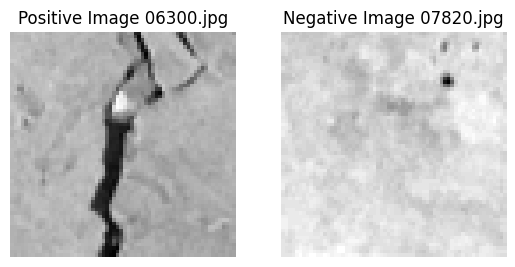

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Define the directory
positive_dir = arunrk7_surface_crack_detection_path+'/Positive'
negative_dir = arunrk7_surface_crack_detection_path+'/Negative'
# Get the list of image filenames
image_files = os.listdir(positive_dir)
image_files_neg = os.listdir(negative_dir)
# Load and preprocess the images
# Image at index 1000
img_path_1 = os.path.join(positive_dir, image_files[1000])
img_1 = Image.open(img_path_1).convert('L')  # Convert to grayscale
img_1 = img_1.resize((64, 64))  # Resize to 64x64
img_1_array = np.array(img_1)  # Convert to numpy array for display

img_path_2 = os.path.join(negative_dir, image_files_neg[1000])
img_2 = Image.open(img_path_2).convert('L')  # Convert to grayscale
img_2 = img_2.resize((64, 64))  # Resize to 64x64
img_2_array = np.array(img_2)  # Convert to numpy array for display

# Create subplots and display the images
plt.subplot(1, 2, 1)
plt.imshow(img_1_array, cmap='gray')
plt.title(f"Positive Image {image_files[1000]}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_2_array, cmap='gray')
plt.title(f"Negative Image {image_files[3000]}")
plt.axis('off')

# Show the plot
plt.show()

In [4]:
from PIL import Image
sample_img_path = os.path.join(arunrk7_surface_crack_detection_path+"/Negative", os.listdir(arunrk7_surface_crack_detection_path+"/Negative")[0])
img = Image.open(sample_img_path)
print(img.size)

(227, 227)


In [5]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 128x128 (or any desired size)
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),  # Convert to tensor and scale to [0, 1]
])

dataset = ImageFolder(root=arunrk7_surface_crack_detection_path, transform=transform)


In [6]:
import torch

from torch.utils.data import DataLoader, random_split

# Define the size of each split
train_size = int(0.8 * len(dataset))  # 80% of the dataset
val_size = int(0.1 * len(dataset))    # 10% of the dataset
test_size = len(dataset) - train_size - val_size  # Remaining 10%

# Set a random seed for reproducibility
torch.manual_seed(0)

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
class CNNModel(nn.Module):
    def __init__(self, input_shape):
        super(CNNModel, self).__init__()

        # First Conv Block: Conv2D -> ReLU -> MaxPool2D
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=64, kernel_size=3, padding="same")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Conv Block: Conv2D -> ReLU -> MaxPool2D
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Conv Block: Conv2D -> ReLU -> MaxPool2D
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        # Flatten is done in forward pass
        self.fc1 = nn.Linear(128 * (input_shape[1] // 8) * (input_shape[2] // 8), 256)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 2)  # Output layer with 2 classes

    def forward(self, x):
        # Apply first conv block
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        # Apply second conv block
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Apply third conv block
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, features)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.batchnorm(x)
        x = F.softmax(self.fc2(x), dim=1)  # Apply softmax for output

        return x



In [8]:
input_shape = (3, 64, 64)  # (channels, height, width)
model = CNNModel(input_shape)

# Print model summary
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Print number of trainable parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

train_losses = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 5
best_acc = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}/{num_epochs} - Training loss: {avg_train_loss}')

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = val_running_loss / len(val_loader)
    accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)
    print(f'Epoch {epoch+1}/{num_epochs} - Validation loss: {avg_val_loss}')
    print(f'Epoch {epoch+1}/{num_epochs} - Validation accuracy: {accuracy}%')

    # Save the model if the current accuracy is the best
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Model improved and saved with accuracy: {accuracy}%')

print('Finished Training')


CNNModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)
2211010
Epoch 1/5 - Training loss: 0.3448509542644024
Epoch 1/5 - Validation loss: 0.3300980052947998
Epoch 1/5 - Validation accuracy: 98.325%
Model improved and saved with accuracy: 98.325%
Epoch 2/5 - Training loss: 0.3313770746588707
Epoch 

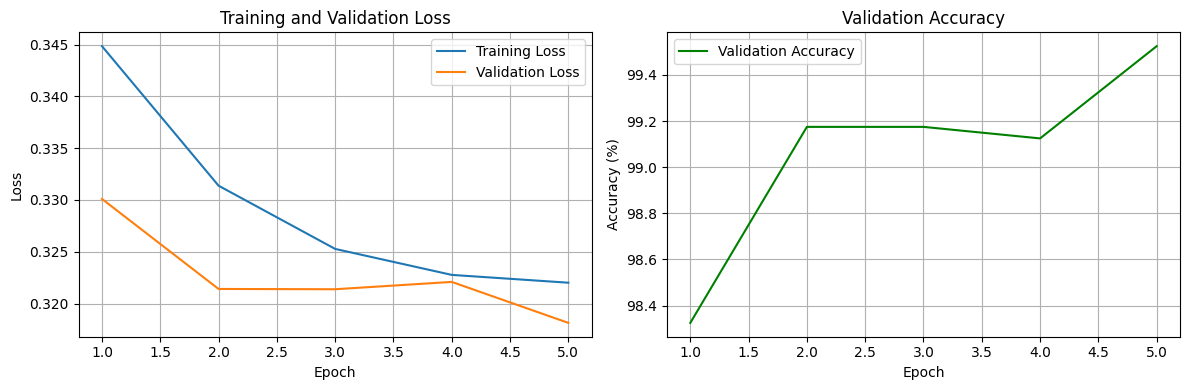

In [9]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
train_losses

[0.3448509542644024,
 0.3313770746588707,
 0.32527179062366485,
 0.3227632603049278,
 0.3220091271996498]

In [11]:
from sklearn.metrics import classification_report
model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
        pred_labels.extend(predicted.cpu().numpy())

# Generate classification report
class_names = ['Negative', 'Positive']  # Match your dataset classes
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      1.00      1.00      1966
    Positive       1.00      0.99      1.00      2034

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [14]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 106.9 MB/s eta 0:00:00


In [15]:
import torch.onnx

# Assuming your SimpleCNN is already trained and loaded with the best weights
model = CNNModel(input_shape)
model.load_state_dict(torch.load('best_model.pth'))  # Load the best saved model
model.eval()  # Set to evaluation mode

# Move model to CPU for export (ONNX export typically works on CPU)
model = model.cpu()

# Define a dummy input tensor with the same shape as your input data
# Your model expects (batch_size, 1, 30, 30) for grayscale 30x30 images
dummy_input = torch.randn(1, 3, 64, 64)  # Batch size of 1 for export

# Export the model to ONNX
onnx_path = "CNNModel.onnx"
torch.onnx.export(
    model,                    # Model to export
    dummy_input,              # Example input tensor
    onnx_path,                # Output file path
    export_params=True,       # Export model parameters
    opset_version=11,         # ONNX opset version (11 is widely compatible)
    do_constant_folding=True, # Optimize by folding constants
    input_names=['input'],    # Name of the input tensor
    output_names=['output'],  # Name of the output tensor
    dynamic_axes={            # Allow dynamic batch size
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print(f"Model exported to {onnx_path}")

Model exported to CNNModel.onnx


In [18]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.1 MB/s eta 0:00:00


In [19]:
import onnx
import onnxruntime as ort
import numpy as np

# Load the ONNX model
onnx_model = onnx.load("CNNModel.onnx")
onnx.checker.check_model(onnx_model)  # Verify the model is valid
print("ONNX model is valid")

# Create an ONNX Runtime session
ort_session = ort.InferenceSession("CNNModel.onnx")

# Prepare a test input (same as dummy_input but as a NumPy array)
test_input = np.random.randn(1, 3, 64, 64).astype(np.float32)

# Run inference with ONNX Runtime
ort_inputs = {ort_session.get_inputs()[0].name: test_input}
ort_outputs = ort_session.run(None, ort_inputs)[0]

# Run inference with PyTorch for comparison
with torch.no_grad():
    pytorch_input = torch.from_numpy(test_input)
    pytorch_output = model(pytorch_input).numpy()

# Compare outputs
print("PyTorch output:", pytorch_output)
print("ONNX output:", ort_outputs)
print("Difference:", np.abs(pytorch_output - ort_outputs).max())

ONNX model is valid
PyTorch output: [[1. 0.]]
ONNX output: [[1. 0.]]
Difference: 0.0


In [20]:
!pip install onnx-simplifier

import onnxsim

# Simplify the model
model_simp, check = onnxsim.simplify("CNNModel.onnx")
onnx.save(model_simp, "CNNModel_simplified.onnx")
print("Model simplified successfully" if check else "Simplification failed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.5 MB/s eta 0:00:00
Model simplified successfully


In [36]:
import onnxruntime as ort
import numpy as np
from PIL import Image

# Load the ONNX model
ort_session = ort.InferenceSession("CNNModel_simplified.onnx")

# Load and preprocess a test image
img_path = arunrk7_surface_crack_detection_path+"/Positive/"+"09999.jpg"
img = Image.open(img_path)
img = img.resize((64, 64))
img_array = np.array(img).astype(np.float32) / 255.0  # Normalize to [0, 1]
img_array = img_array.reshape(1, 3, 64, 64)

# Run inference
ort_inputs = {ort_session.get_inputs()[0].name: img_array}
ort_outputs = ort_session.run(None, ort_inputs)[0]
predicted_class = np.argmax(ort_outputs, axis=1)[0]

# Map prediction to class name
class_names = ['Negative', 'Positive']
print(f"Predicted class: {class_names[predicted_class]}")

Predicted class: Positive
